In [7]:
%load_ext autoreload
%autoreload 2
from expressiveness_benchmark.types import Plan, Task, Language, SourceRange, Program
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from interval import interval
from itertools import combinations
sns.set(style='whitegrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
LANG_ORDER = ['python-imperative', 'python-functional', 'python-pandas', 'r', 'sql', 'datalog', 'q']

In [20]:
import subprocess as sp
for p in Program._load_all():
    try:
        p.ntokens()
    except sp.CalledProcessError as e:
        print(p)
        print(e.stderr.decode('utf-8'))
        raise

In [22]:
programs = Program.load_all()
tasks = Task.load_all()

programs = programs[programs.plan != {}] # filter where plan hasn't been labeled
programs = programs[programs.task.isin(tasks.id.tolist())] # filter programs associated to a missing task
programs['category'] = programs.task.map(lambda t: tasks[tasks.id == t].category.iloc[0])

In [5]:
programs

,task,language,plan,source,author,implementation,category
0,tom_hanks,python-imperative,"{'director': [{'line': 7, 'start': 10, 'end': ...","\ndef tom_hanks(actors,directors):\n r_direct...",g,,Basic
1,tom_hanks,python-pandas,"{'director': [{'line': 4, 'start': 2, 'end': 3...","\ndef tom_hanks(actors,directors):\n movies =...",g,,Basic
2,tom_hanks,r,"{'actor': [{'line': 2, 'start': 4, 'end': 36}]...","tom_hanks <- function(actors, directors) {\n ...",g,,Basic
3,tom_hanks,q,"{'director': [{'line': 1, 'start': 3, 'end': 1...",tom_hanks: {[actors; directors]\n (select dir...,g,,Basic
4,tom_hanks,sql,"{'director': [{'line': 1, 'start': 0, 'end': 2...",\nSELECT directors.director\nFROM \n director...,g,,Basic
...,...,...,...,...,...,...,...
127,average_adjacent,sql,"{'order': [{'line': 3, 'start': 28, 'end': 41}...","SELECT\n time, (x + next) / 2 as x\nFROM (SEL...",scott,,Time Series
128,average_adjacent,python-imperative,"{'order': [{'line': 5, 'start': 2, 'end': 36}]...",def average_adjacent(data):\n if len(data) ==...,scott,,Time Series
129,average_adjacent,python-functional,"{'order': [{'line': 1, 'start': 0, 'end': 48}]...",def average_adjacent(data):\n data = sorted(d...,scott,,Time Series
130,average_adjacent,python-pandas,"{'average': [{'line': 4, 'start': 2, 'end': 39...",def average_adjacent(data):\n data = data.sor...,scott,,Time Series


# Global analysis

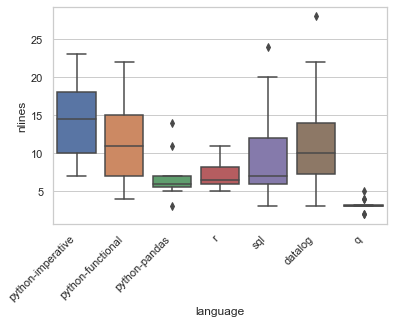

In [8]:
programs['nlines'] = programs.source.map(lambda s: len(s.split('\n')))
ax = sns.boxplot(data=programs, x='language', y='nlines', order=LANG_ORDER)
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')

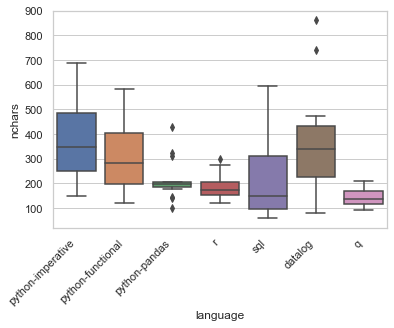

In [9]:
programs['nchars'] = programs.source.map(len)
ax = sns.boxplot(data=programs, x='language', y='nchars', order=LANG_ORDER)
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')

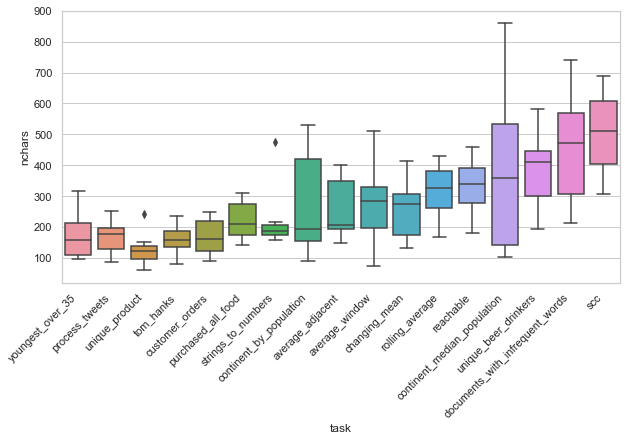

In [139]:
_, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=programs, x='task', y='nchars', 
            order=programs.groupby('task').nlines.mean().sort_values().index, 
            ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')

# Grouped analysis

In [140]:
from scipy.stats import zscore, rankdata

def bestworst(inner_group, outer_group, measure='nchars', score=zscore):
    df = programs.groupby('task', as_index=False).apply(
        lambda rows: rows.assign(
            metric=score(rows[measure]))).reset_index()

    def f(df):
        df = df.groupby(inner_group).metric.mean()
        return pd.DataFrame([{'best': df.index[df.argmin()], 'worst': df.index[df.argmax()]}])

    return df.groupby(outer_group).apply(f).reset_index(level=-1, drop=True)

In [141]:
for group in ['category', 'task']:
    for score in [zscore]: # rankdata
        print(f'GROUP: {group}, SCORE: {score.__name__}')
        print(bestworst(group, 'language', score=score))
        print()

GROUP: category, SCORE: zscore
                                best    worst
language                                     
datalog                       Graphs  Strings
python-functional        Time Series    Joins
python-imperative            Strings    Joins
python-pandas            Aggregation    Joins
q                  First-order logic    Joins
r                        Aggregation    Basic
sql                      Time Series  Strings

GROUP: task, SCORE: zscore
                                          best                 worst
language                                                            
datalog                              tom_hanks    strings_to_numbers
python-functional             average_adjacent       customer_orders
python-imperative           strings_to_numbers             tom_hanks
python-pandas      continent_median_population       customer_orders
q                         unique_beer_drinkers    strings_to_numbers
r                         unique_beer_drinke

In [142]:
for group in ['category', 'task']:
    for score in [zscore]: # rankdata
        print(f'GROUP: {group}, SCORE: {score.__name__}')
        print(bestworst('language', group, score=score))
        print()

GROUP: category, SCORE: zscore
                            best              worst
category                                           
Aggregation        python-pandas            datalog
Basic                        sql  python-imperative
First-order logic              q            datalog
Graphs                   datalog  python-imperative
Joins                    datalog  python-imperative
Strings                        q            datalog
Time Series                  sql  python-imperative

GROUP: task, SCORE: zscore
                                              best              worst
task                                                                 
average_adjacent                               sql  python-imperative
average_window                                 sql  python-imperative
changing_mean                                  sql            datalog
continent_by_population                        sql  python-imperative
continent_median_population                      q   

# Plan analysis

In [102]:
def analyze_plan_size(task_id):
    task = tasks[tasks.id == task_id].iloc[0]
    progs = programs[programs.task == task_id]
    goals = pd.DataFrame(task.plan)

    plan_size = progs.apply(
        lambda p: pd.DataFrame([{
            'goal': goals[goals.id == k].iloc[0].description,
            'language': p.language,
            'metric': sum([span['end'] - span['start'] for span in v]),

        } for k,v in p.plan.items()]), 
        axis=1)
    df = pd.concat(plan_size.tolist())
    df = df.groupby('goal', as_index=False) \
        .apply(lambda rows: rows.assign(score=zscore(rows.metric))).reset_index()
    
    print('WORST PLAN BY SIZE')
    print(df.loc[df.groupby('language').score.idxmax()][['language', 'goal']])
    print()
    print('BEST PLAN BY SIZE')
    print(df.loc[df.groupby('language').score.idxmin()][['language', 'goal']])

In [143]:
analyze_plan_size('strings_to_numbers')

WORST PLAN BY SIZE
             language           goal
23            datalog       removing
11  python-functional    in each row
12  python-imperative    in each row
14      python-pandas  into a number
10                  q    in each row
13                  r    in each row
15                sql  into a number

BEST PLAN BY SIZE
             language                                               goal
9             datalog                                        in each row
18  python-functional                                      into a number
19  python-imperative                                      into a number
0       python-pandas  commas if format is "comma_sep" and underscore...
17                  q                                      into a number
6                   r  commas if format is "comma_sep" and underscore...
8                 sql                                        in each row


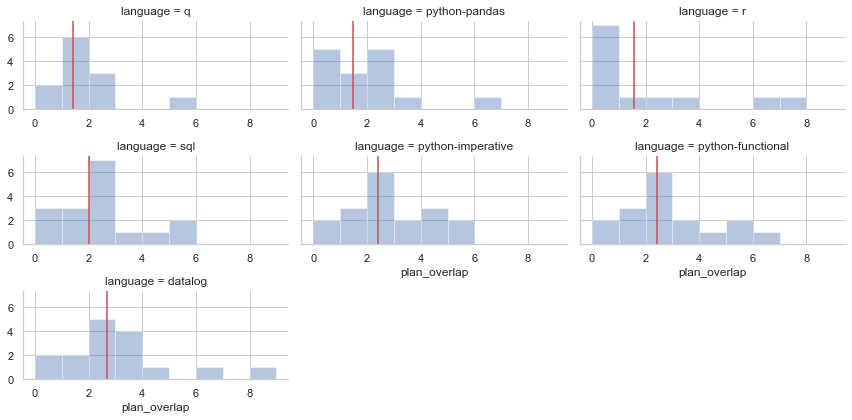

In [34]:
def coord_to_1d(lines, line, column):
    return sum([len(l) for l in lines[:line]]) + column        
    
def plan_overlap(row):
    lines = row.source.split('\n')
    plan_df = pd.DataFrame([{'key': k, **v} for k, vs in row.plan.items() for v in vs])
    plan_df['byte_start'] = plan_df.apply(lambda row: coord_to_1d(lines, row.line, row.start), axis=1)
    plan_df['byte_end'] = plan_df.apply(lambda row: coord_to_1d(lines, row.line, row.end), axis=1)

    full_intervals = plan_df.groupby('key').apply(
        lambda rows: interval[rows.byte_start.min(), rows.byte_end.max()])
    all_pairs = combinations(full_intervals.tolist(), r=2)
    return sum([1 if l & r else 0 for (l, r) in all_pairs])

programs['plan_overlap'] = programs.apply(plan_overlap, axis=1)
order = programs.groupby('language').plan_overlap.mean().sort_values().index.values
g = sns.FacetGrid(data=programs, col='language', col_wrap=3, aspect=2, height=2, col_order=order)
g.map(sns.distplot, 'plan_overlap', kde=False, bins=np.arange(0, programs.plan_overlap.max()+1))
for i, ax in enumerate(g.axes.flatten()):
    ax.axvline(programs[programs.language == order[i]].plan_overlap.mean(), color='r')
    ax.tick_params(labelbottom=True)    
plt.tight_layout()